## Project Overview

### Problem Statement
In today's digital world, understanding how Reddit communities function is crucial for moderators, users, and researchers...

### Data Collection Overview
- **Tools**:
  - PRAW (Python Reddit API Wrapper)
  - BeautifulSoup / Scrapy
  
- **Data Points to Collect**:
  - **Posts**: Title, content, upvotes...
  - **Comments**: Content, upvotes...
  
### Solution Approach
1. **Sentiment & Engagement Analysis**
   - Visualizations using Matplotlib and Seaborn...
   
2. **Correlation Analysis**
   - Apply classification algorithms using scikit-learn...

### Expected Deliverables
- Insight Report
- Actionable Recommendations

## Setup Environment

### Purpose
This section prepares our Google Colab environment for the Reddit Communities analysis project as outlined in our team's proposal. We'll install the necessary Python libraries to handle data collection, processing, analysis, and visualization.

### Key Libraries
- PRAW: For accessing the Reddit API
- pandas: For data manipulation and analysis
- numpy: For numerical computing
- matplotlib and seaborn: For data visualization
- nltk: For natural language processing and sentiment analysis
- scikit-learn: For machine learning tasks

### Alignment with Project Goals
These libraries support our objectives of:
1. Analyzing moderation strategies
2. Predicting post impact
3. Visualizing Reddit community interactions


# 1. Setup and Installation
Make sure to install all necessary libraries first:

In [14]:
%pip install praw

Note: you may need to restart the kernel to use updated packages.


# 2. Importing Libraries

In [15]:
import numpy as np
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import praw  
import time 

# 3. Initialize Reddit API
Define and call a function to authenticate with the Reddit API:

In [16]:
def setup_reddit_api():
    return praw.Reddit(
        client_id="nrakGjG_wnBE_5UdcHNJoQ",
        client_secret="qmGr1q_4pGIBR0pYJE8cyhUbTbdX2w",
        user_agent="LittleCheesyExplorers/1.0 (Reddit Communities Analysis Project)"
    )

reddit = setup_reddit_api()

print(reddit.user.me())  

None


# 4. Load Read required Subreddits 
This code block will store the names of the subreddits that we want to collect data from.

The names will be stored in a text file and we will read from that and scrape based on that list.

In [17]:
with open('subreddits.txt', 'r') as file:
    subreddit_list = [line.strip() for line in file if line.strip()]

print(subreddit_list)

['AskReddit', 'ChangeMyView', 'TodayILearned', 'self', 'offmychest', 'Showerthoughts', 'personalfinance', 'AskScience', 'Writing', 'Advice', 'LetsNotMeet', 'SelfImprovement', 'DecidingToBeBetter', 'AskHistorians', 'TwoXChromosomes', 'CasualConversation', 'InternetIsBeautiful', 'nosleep', 'WritingPrompts', 'ExplainLikeImFive', 'TrueOffMyChest', 'UnpopularOpinion', 'relationships', 'TrueAskReddit', 'Confession', 'ShortScaryStories', 'ProRevenge', 'NuclearRevenge', 'LifeProTips', 'needadvice', 'TrueUnpopularOpinion']


# 5. Functions to Collect Data from Reddit
Define functions to collect posts, comments, and subreddit-level data. This is separated for modularity and ease of testing:

### 5.1 Collect Posts from a Subreddit

In [18]:
def collect_subreddit_posts(subreddit_name, post_limit=10):
    subreddit = reddit.subreddit(subreddit_name)
    posts_data = []

    for post in subreddit.hot(limit=post_limit):
        posts_data.append({
            'subreddit': subreddit_name,
            'title': post.title,
            'content': post.selftext,
            'upvotes': post.score,
            'upvote_ratio': post.upvote_ratio,
            'comments_count': post.num_comments,
            'author': post.author.name if post.author else '[deleted]',
            'timestamp': datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
            'post_id': post.id
        })

    return pd.DataFrame(posts_data)

### 5.2 Collect Data from Multiple Subreddits

In [19]:
def collect_posts_from_subreddits(subreddit_list, post_limit=10):
    all_posts = []

    for subreddit_name in subreddit_list:
        print(f"Collecting posts from r/{subreddit_name}")
        try:
            posts_df = collect_subreddit_posts(subreddit_name, post_limit)
            all_posts.append(posts_df)
            print(f"Collected {len(posts_df)} posts from r/{subreddit_name}")
        except Exception as e:
            print(f"Error collecting posts from r/{subreddit_name}: {str(e)}")

    combined_df = pd.concat(all_posts, ignore_index=True)
    return combined_df


### 5.3 Collect Subreddit-Level Data (Moderators, Rules, Subscriber Counts)
Functions to collect metadata for each subreddit, including subscriber count, rules, and moderator counts:

In [20]:
def collect_subreddit_level_data(reddit, subreddits, limit=10): 
    subreddit_level_data = []

    for subreddit_name in subreddits[:limit]:
        try:
            subreddit = reddit.subreddit(subreddit_name)

            subscriber_count = subreddit.subscribers

            try:
                rules = list(subreddit.rules())
                num_rules = len(rules)
                rule_severity = [rule.severity for rule in rules]
            except Exception as rule_error:
                num_rules = 0
                rule_severity = []
                print(f"Could not fetch rules for r/{subreddit_name}: {rule_error}")

            try:
                moderators = len(list(subreddit.moderators()))
            except Exception as mod_error:
                moderators = 0
                print(f"Could not fetch moderators for r/{subreddit_name}: {mod_error}")

            subreddit_data = {
                "subreddit_name": subreddit_name,
                "subscriber_count": subscriber_count,
                "num_rules": num_rules,
                "moderator_count": moderators,
                "rule_severity": rule_severity
            }
            subreddit_level_data.append(subreddit_data)

        except Exception as e:
            print(f"Error fetching data for subreddit {subreddit_name}: {e}")

    return subreddit_level_data


# Collecting Comments method


In [21]:
"""def collect_top_level_comments_from_csv(csv_file, comment_limit=2):
    # Read posts from CSV file
    posts_df = pd.read_csv(csv_file)
    comments_data = []

    # Iterate through each post in the CSV file
    for _, row in posts_df.iterrows():
        post_id = row['post_id']  # 'post_id' column from your CSV
        subreddit_name = row['subreddit']  # 'subreddit' column from your CSV
        
        try:
            # Fetch the post using the post ID
            post = reddit.submission(id=post_id)
            post.comments.replace_more(limit=0)  # Ensure all top-level comments are loaded
            
            # Debug: Print post details to confirm it's being processed
            print(f"Processing post {post_id} in subreddit {subreddit_name}")
            
            # Check if the post has comments
            if not post.comments:
                print(f"No comments found for post {post_id}")
                continue

            # Collect top-level comments
            for comment in post.comments[:comment_limit]:  # Limit to the top `comment_limit` comments
                if comment.parent_id.split('_')[1] == post_id:  # Ensure it's a top-level comment
                    
                    # Get comment author and karma (handle potential missing authors)
                    author_karma = 0
                    author_name = "[deleted]"
                    
                    if comment.author:
                        author_name = comment.author.name
                        author_karma = comment.author.link_karma + comment.author.comment_karma  # Total karma

                    comments_data.append({
                        'subreddit': subreddit_name,
                        'comment': comment.body,
                        'comment_author': author_name,
                        'author_karma': author_karma,
                        'post_title': post.title,
                        'post_content': post.selftext,
                        'post_upvotes': post.score,
                        'timestamp': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    })
            
            print(f"Collected {len(comments_data)} comments from post {post_id}")
        
        except Exception as e:
            print(f"Error collecting comments from post {post_id}: {e}")
        
        # Optional: Small delay to avoid hitting rate limits
        time.sleep(1) 
    
    # Return the DataFrame of collected comments
    return pd.DataFrame(comments_data)

"""

def collect_top_level_comments(csv_file, comment_limit=2):
    # Read the CSV containing post information
    posts_df = pd.read_csv(csv_file)
    comments_data = []

    # Loop through the DataFrame rows and extract post_id and subreddit
    for _, row in posts_df.iterrows():
        post_id = row['post_id']  # Ensure the CSV has a 'post_id' column
        subreddit_name = row['subreddit']  # Ensure the CSV has a 'subreddit' column

        try:
            # Get the post by its ID
            post = reddit.submission(id=post_id)
            post.comments.replace_more(limit=0)  # Ensure we get all comments

            # Debugging: Print post details to ensure it's fetched
            print(f"Processing post {post_id} from subreddit {subreddit_name}")

            # Collect top-level comments (limit to 'comment_limit' comments per post)
            for comment in post.comments[:comment_limit]:  # Limiting the number of comments
                if comment.parent_id.split('_')[1] == post_id:  # Check if it's a top-level comment
                    # Initialize author details
                    author_karma = 0
                    author_name = "[deleted]"
                    
                    if comment.author:
                        author_name = comment.author.name
                        author_karma = comment.author.link_karma + comment.author.comment_karma  # Total karma

                    # Add the comment data to the list
                    comments_data.append({
                        'subreddit': subreddit_name,
                        'comment': comment.body,
                        'comment_author': author_name,
                        'author_karma': author_karma,
                        'post_title': post.title,
                        'post_content': post.selftext,
                        'post_upvotes': post.score,
                        'timestamp': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    })

            print(f"Collected {len(comments_data)} comments from post {post_id}")
        
        except Exception as e:
            print(f"Error collecting comments from post {post_id}: {e}")
        
        # Small delay to avoid Reddit API rate limits
        time.sleep(1) 
    
    # Return the collected comments as a DataFrame
    return pd.DataFrame(comments_data)

def save_comments_to_csv(csv_file, comment_limit=2):
    comments_df = collect_top_level_comments(csv_file, comment_limit)
    
    # Check if the DataFrame has data
    if comments_df.empty:
        print("No comments collected.")
    else:
        comments_df.to_csv("top_level_comments.csv", index=False)
        print("\nComments saved to collected_comments_with_author_and_karma.csv")

"""
    # Read the post IDs and other data from the provided CSV file
    posts_df = pd.read_csv(csv_file)
    comments_data = []
    
    for _, row in posts_df.iterrows():
        post_id = row['post_id']
        subreddit_name = row['subreddit']
        
        try:
            # Fetch the post using the post_id
            post = reddit.submission(id=post_id)
            
            # Replace "MoreComments" with empty (expand all top-level comments)
            post.comments.replace_more(limit=0)
            
            # Iterate through top-level comments
            top_comments = [comment for comment in post.comments if isinstance(comment, praw.models.Comment)]
            
            # Limit the number of comments to comment_limit
            for comment in top_comments[:comment_limit]:  
                comments_data.append({
                    'subreddit': subreddit_name,
                    'comment': comment.body,
                    'comment_author': comment.author.name if comment.author else '[deleted]',
                    'author_karma': (comment.author.link_karma + comment.author.comment_karma) if comment.author else 0,
                    'post_title': post.title,
                    'post_content': post.selftext,
                    'post_upvotes': post.score,
                    'timestamp': datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                })
            
            print(f"Collected {len(top_comments[:comment_limit])} comments from post {post_id}")
        
        except Exception as e:
            print(f"Error collecting comments from post {post_id}: {e}")
        
        # Optional: Small delay to avoid hitting rate limits
        time.sleep(1) 
    
    return pd.DataFrame(comments_data)

"""

# Example usage
# save_comments_to_csv("reddit_posts.csv", comment_limit=2)"""

'\n    # Read the post IDs and other data from the provided CSV file\n    posts_df = pd.read_csv(csv_file)\n    comments_data = []\n    \n    for _, row in posts_df.iterrows():\n        post_id = row[\'post_id\']\n        subreddit_name = row[\'subreddit\']\n        \n        try:\n            # Fetch the post using the post_id\n            post = reddit.submission(id=post_id)\n            \n            # Replace "MoreComments" with empty (expand all top-level comments)\n            post.comments.replace_more(limit=0)\n            \n            # Iterate through top-level comments\n            top_comments = [comment for comment in post.comments if isinstance(comment, praw.models.Comment)]\n            \n            # Limit the number of comments to comment_limit\n            for comment in top_comments[:comment_limit]:  \n                comments_data.append({\n                    \'subreddit\': subreddit_name,\n                    \'comment\': comment.body,\n                    \'com

# 6 Analyze and Label Engagement for Posts
Calculates engagement scores and labels posts with engagement levels:

In [22]:

def calculate_engagement(post):
    upvotes = post['upvotes']
    comments_count = post['comments_count']
    subscribers = post['subscriber_count']
    
    if subscribers > 0:
        engagement = (upvotes + comments_count) / subscribers
    else:
        engagement = 0  
    return engagement

def define_engagement(posts_df):
    def label_engagement(score):
        if score < 0.0025:
            return "Low"
        elif score < 0.0050:
            return "Medium"
        else:
            return "High"
    posts_df['engagement_level'] = posts_df['normalized_engagement'].apply(label_engagement)
    return posts_df




### 6.1 Define Engagement Levels

In [23]:
def define_engagement(posts_df):
    def label_engagement(score):
        if score < 1:
            return "Low"
        elif score < 5:
            return "Medium"
        else:
            return "High"
    
    posts_df['engagement_level'] = posts_df['normalized_engagement'].apply(label_engagement)
    return posts_df


# 7. Add Features to Posts

In [24]:
def add_features_to_posts(df):
    df['title_length'] = df['title'].apply(len)
    df['post_length'] = df['content'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    df['time_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()

    return df

# 9. Running All Methods
Finally, running all the methods in order 

In [25]:
# Collect posts from all subreddits
all_posts_df = collect_posts_from_subreddits(subreddit_list, post_limit=4)

# Save all collected posts to a single CSV file
csv_filename = "subreddit_posts.csv"
all_posts_df.to_csv(csv_filename, index=False)
print(f"\nAll posts data saved to {csv_filename}")

# Print summary of collected posts
print("\nSummary of collected posts:")
print(all_posts_df['subreddit'].value_counts())

# Collect subreddit-level data (e.g., rules, moderation, etc.)
subreddit_level_data = collect_subreddit_level_data(reddit, subreddit_list, limit=20)

# Convert to DataFrame and save to CSV
subreddit_level_df = pd.DataFrame(subreddit_level_data)
subreddit_level_df.to_csv("subreddit_level_data.csv", index=False)
print("\nSubreddit-level data saved to subreddit_level_data.csv")



# Save updated posts data with engagement scores to CSV
all_posts_df.to_csv("subreddit_posts_with_engagement.csv", index=False)
print("\nSubreddit posts with engagement scores saved to subreddit_posts_with_engagement.csv")

# Run the function to collect top-level comments and save them to a new CSV
# save_comments_to_csv("subreddit_posts.csv", comment_limit=2)

cleaned_labeled_data = pd.read_csv("cleaned_labeled_subreddit_posts.csv")
cleaned_labeled_data = cleaned_labeled_data.merge(subreddit_level_df[['subreddit_name', 'subscriber_count']], 
                                                  left_on='subreddit', right_on='subreddit_name', how='left')

cleaned_labeled_data['engagement'] = cleaned_labeled_data.apply(calculate_engagement, axis=1)
cleaned_labeled_data['normalized_engagement'] = cleaned_labeled_data['engagement'] * 10000

cleaned_labeled_data = define_engagement(cleaned_labeled_data)

cleaned_labeled_data.to_csv("labeled_subreddit_posts.csv", index=False)
print("\nUpdated data with engagement levels saved to labeled_subreddit_posts.csv")

print("\nDisplaying updated dataframe with engagement scores:")
print(cleaned_labeled_data.head())  

Collected 4 posts from r/AskReddit
Collected 4 posts from r/ChangeMyView
Collected 4 posts from r/TodayILearned
Collected 4 posts from r/self
Collected 4 posts from r/offmychest
Collected 4 posts from r/Showerthoughts
Collected 4 posts from r/personalfinance
Collected 4 posts from r/AskScience
Collected 4 posts from r/Writing
Collected 4 posts from r/Advice
Collected 4 posts from r/LetsNotMeet
Collected 4 posts from r/SelfImprovement
Collected 4 posts from r/DecidingToBeBetter
Collected 4 posts from r/AskHistorians
Collected 4 posts from r/TwoXChromosomes
Collected 4 posts from r/CasualConversation
Collected 4 posts from r/InternetIsBeautiful
Collected 4 posts from r/nosleep
Collected 4 posts from r/WritingPrompts
Collected 4 posts from r/ExplainLikeImFive
Collected 4 posts from r/TrueOffMyChest
Collected 4 posts from r/UnpopularOpinion
Collected 4 posts from r/relationships
Collected 4 posts from r/TrueAskReddit
Collected 4 posts from r/Confession
Collected 4 posts from r/ShortScarySt

C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\3403129084.py:11: DeprecationWarning: Calling SubredditRules to get a list of rules is deprecated. Remove the parentheses to use the iterator. View the PRAW documentation on how to change the code in order to use the iterator (https://praw.readthedocs.io/en/latest/code_overview/other/subredditrules.html#praw.models.reddit.rules.SubredditRules.__call__).
  rules = list(subreddit.rules())


Could not fetch rules for r/ChangeMyView: 'str' object has no attribute 'severity'
Could not fetch moderators for r/ChangeMyView: 'Subreddit' object has no attribute 'moderators'
Could not fetch rules for r/TodayILearned: 'str' object has no attribute 'severity'
Could not fetch moderators for r/TodayILearned: 'Subreddit' object has no attribute 'moderators'
Could not fetch rules for r/self: 'str' object has no attribute 'severity'
Could not fetch moderators for r/self: 'Subreddit' object has no attribute 'moderators'
Could not fetch rules for r/offmychest: 'str' object has no attribute 'severity'
Could not fetch moderators for r/offmychest: 'Subreddit' object has no attribute 'moderators'
Could not fetch rules for r/Showerthoughts: 'str' object has no attribute 'severity'
Could not fetch moderators for r/Showerthoughts: 'Subreddit' object has no attribute 'moderators'
Could not fetch rules for r/personalfinance: 'str' object has no attribute 'severity'
Could not fetch moderators for r/

# EDA

Basic Exploratory Data Analysis

We will explore distribution of key variables here

In [26]:
import seaborn as sns

In [27]:
df = pd.read_csv("cleaned_labeled_subreddit_posts.csv")

C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\131603132.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['subreddit'] == subreddit]['upvotes'], label=subreddit, fill=True, alpha=0.5)


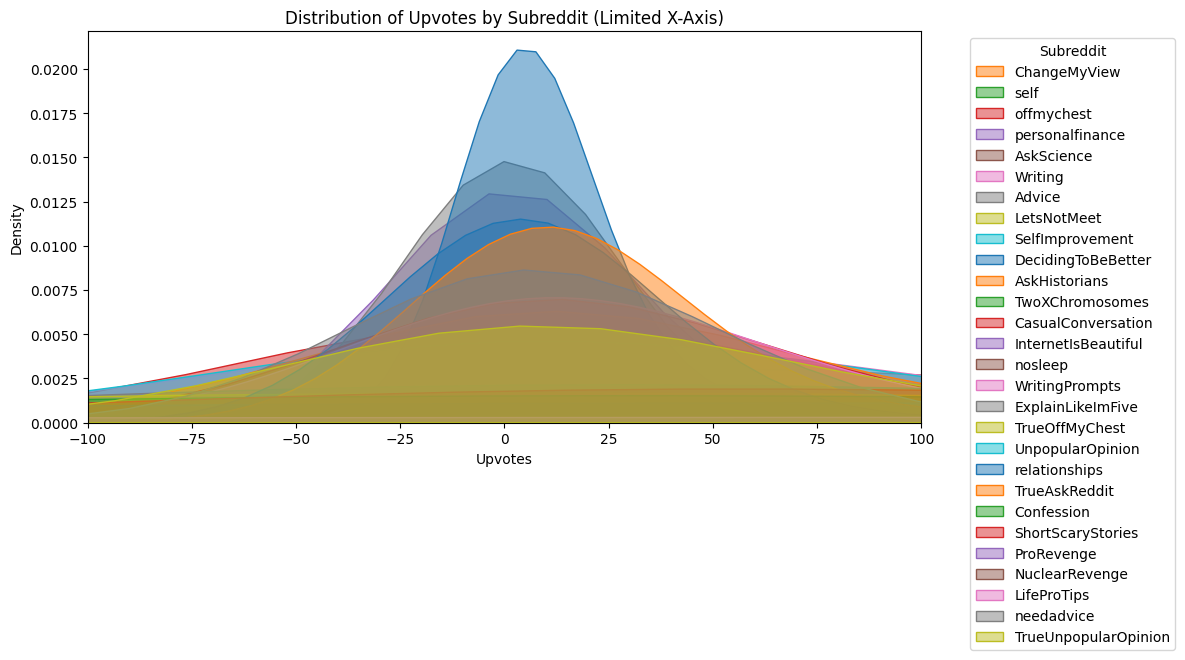

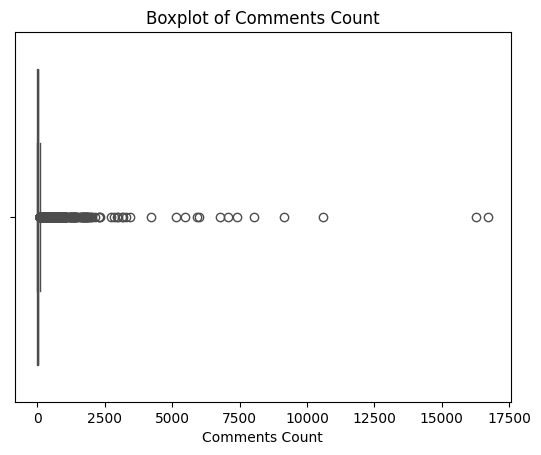

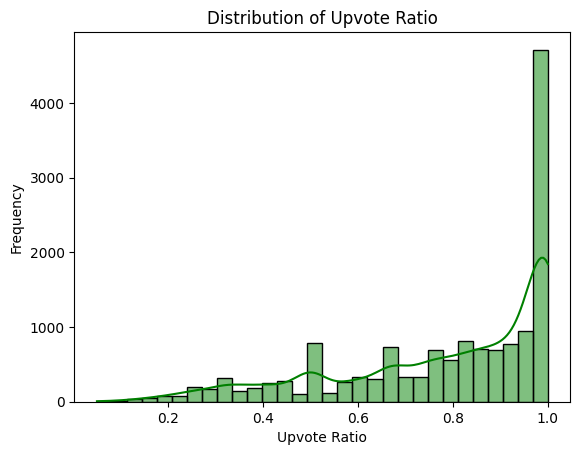

In [35]:
# Calculate the 95th percentile of upvotes
upvote_limit = df['upvotes'].quantile(0.95)

# Plot KDE with x-axis limited to the 95th percentile
plt.figure(figsize=(12, 6))
for subreddit in df['subreddit'].unique():
    sns.kdeplot(df[df['subreddit'] == subreddit]['upvotes'], label=subreddit, fill=True, alpha=0.5)
plt.title('Distribution of Upvotes by Subreddit (Limited X-Axis)')
plt.xlabel('Upvotes')
plt.ylabel('Density')
plt.xlim(-100,100)  # Set the x-axis limit to the 95th percentile
plt.legend(title='Subreddit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

sns.boxplot(x=df['comments_count'], color='orange')
plt.title('Boxplot of Comments Count')
plt.xlabel('Comments Count')
plt.show()



# Distribution of 'upvote_ratio'
sns.histplot(df['upvote_ratio'], kde=True, color='green', bins=30)
plt.title('Distribution of Upvote Ratio')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')
plt.show()



Subreddit Analysis

subreddit
ShortScaryStories       979
LetsNotMeet             975
Advice                  932
self                    922
TrueOffMyChest          903
offmychest              890
TrueUnpopularOpinion    863
personalfinance         862
AskScience              822
DecidingToBeBetter      774
AskHistorians           760
CasualConversation      742
nosleep                 557
Writing                 535
TwoXChromosomes         440
SelfImprovement         412
NuclearRevenge          404
ChangeMyView            383
needadvice              340
LifeProTips             332
ExplainLikeImFive       262
relationships           218
UnpopularOpinion        204
TrueAskReddit           201
Confession              174
WritingPrompts           70
ProRevenge               44
InternetIsBeautiful       5
AskReddit                 1
Name: count, dtype: int64


C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\491468318.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=subreddit_counts.values, y=subreddit_counts.index, palette="Blues_d")
C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\491468318.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)


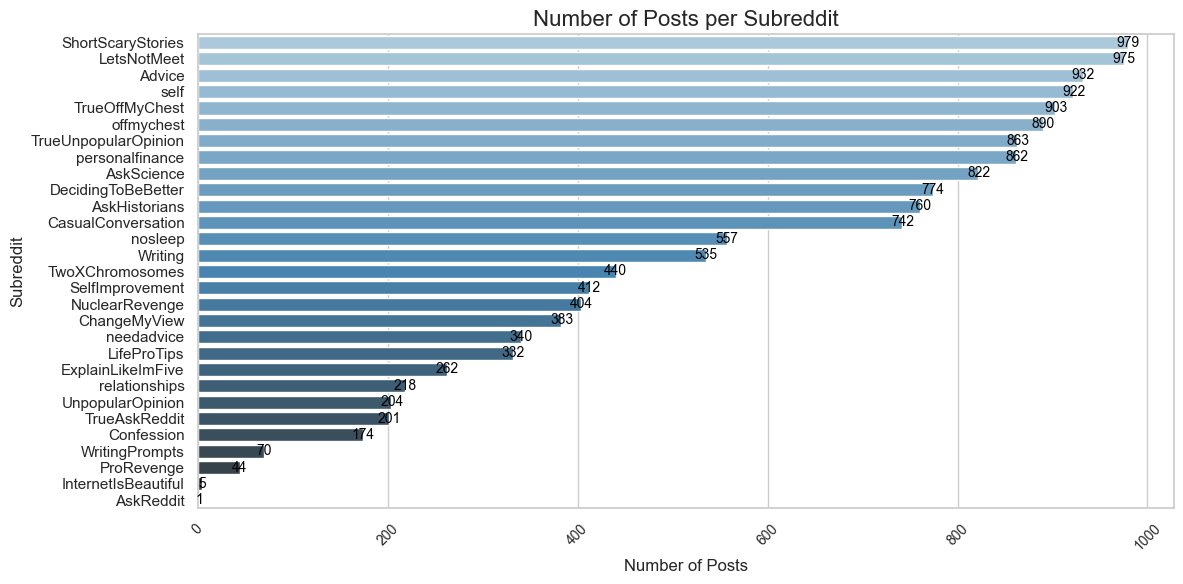

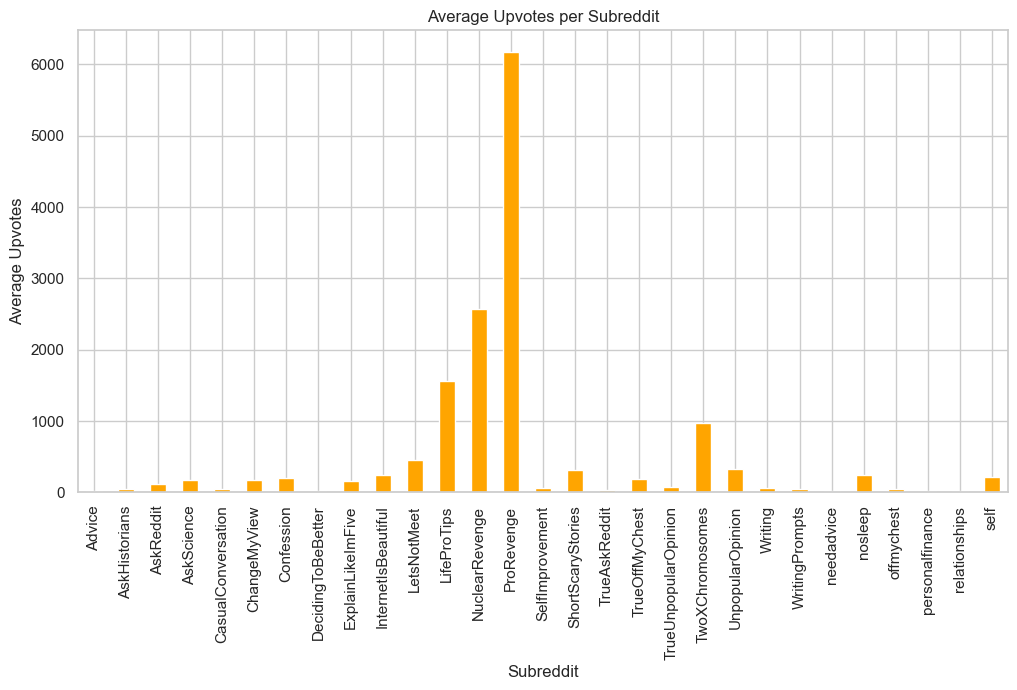

C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\491468318.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_comments_per_subreddit.values, y=avg_comments_per_subreddit.index, palette="Greens_d")
C:\Users\varsh\AppData\Local\Temp\ipykernel_33632\491468318.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(tick)}' for tick in ax.get_xticks()], rotation=45, fontsize=10)


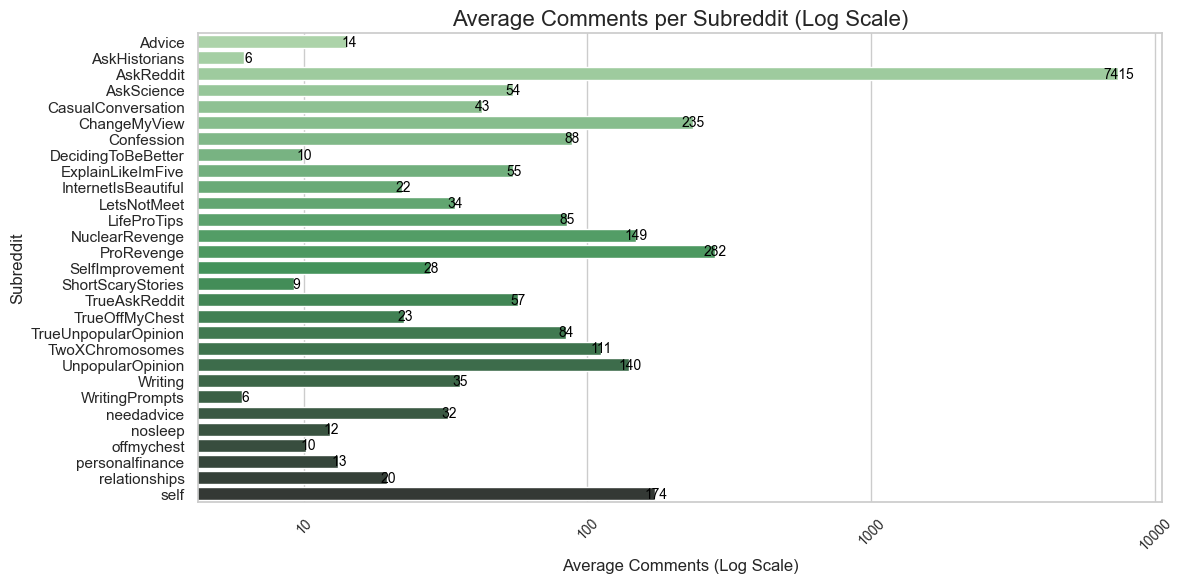

In [42]:
# Number of posts per subreddit
subreddit_counts = df['subreddit'].value_counts()
print(subreddit_counts)

# Plot number of posts per subreddit
sns.set(style="whitegrid")

# Plot number of posts per subreddit
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=subreddit_counts.values, y=subreddit_counts.index, palette="Blues_d")
ax.set_title('Number of Posts per Subreddit', fontsize=16)
ax.set_xlabel('Number of Posts', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 0.2, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()

# Average upvotes per subreddit
avg_upvotes_per_subreddit = df.groupby('subreddit')['upvotes'].mean()
avg_upvotes_per_subreddit.plot(kind='bar', color='orange', figsize=(12, 6))
plt.title('Average Upvotes per Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Upvotes')
plt.xticks(rotation=90)
plt.show()

# Plot average comments per subreddit with a horizontal bar chart and log scale
plt.figure(figsize=(12, 6))
avg_comments_per_subreddit = df.groupby('subreddit')['comments_count'].mean()
ax = sns.barplot(x=avg_comments_per_subreddit.values, y=avg_comments_per_subreddit.index, palette="Greens_d")
ax.set_title('Average Comments per Subreddit (Log Scale)', fontsize=16)
ax.set_xlabel('Average Comments (Log Scale)', fontsize=12)
ax.set_ylabel('Subreddit', fontsize=12)
ax.set_xscale('log')  # Logarithmic scale for the x-axis
ax.set_xticklabels([f'{int(tick)}' for tick in ax.get_xticks()], rotation=45, fontsize=10)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 0.2, p.get_y() + p.get_height() / 2), 
                ha='center', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()


# FINAL CLEANED CSV Creation and Storing
In this Code Block we will be creating a csv file and storing all our scraped data.

VISUALIZATION

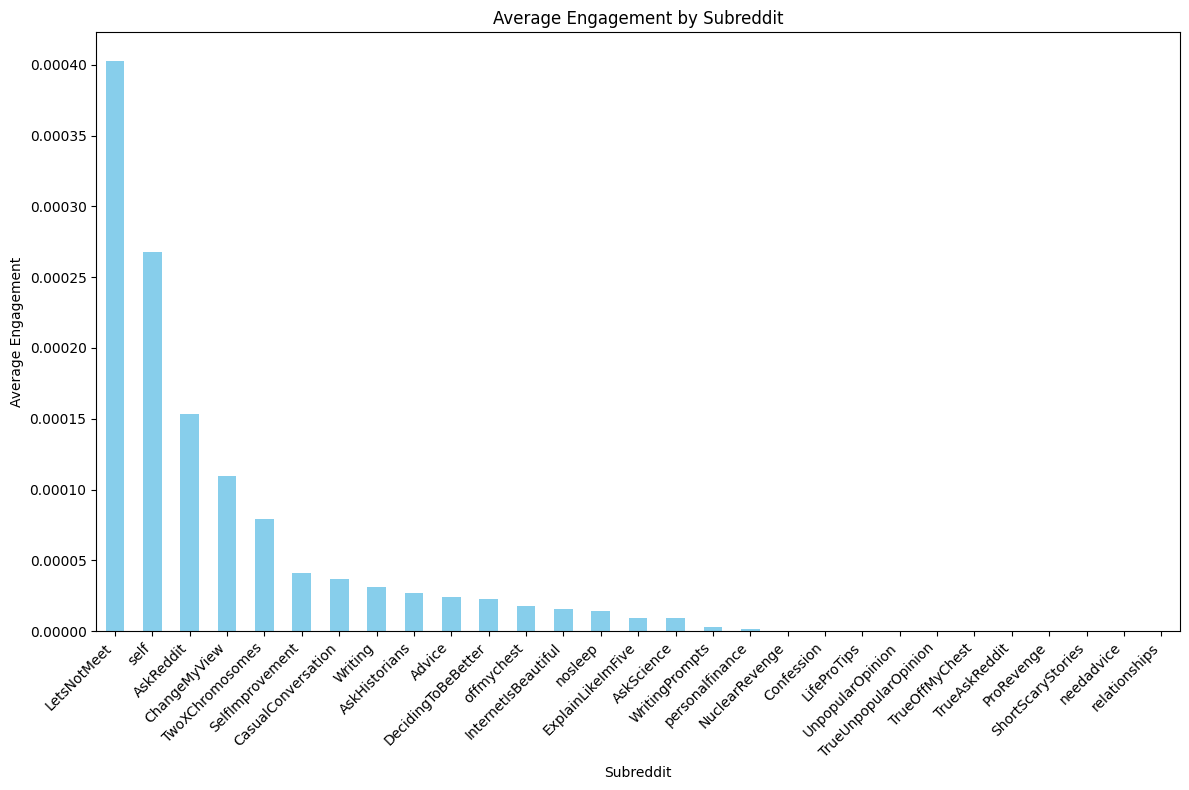

Subreddits with Highest Engagement:
subreddit
LetsNotMeet        0.000403
self               0.000268
AskReddit          0.000153
ChangeMyView       0.000110
TwoXChromosomes    0.000079
Name: engagement, dtype: float64

Subreddits with Lowest Engagement:
subreddit
TrueAskReddit        0.0
ProRevenge           0.0
ShortScaryStories    0.0
needadvice           0.0
relationships        0.0
Name: engagement, dtype: float64


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('labeled_subreddit_posts.csv')

subreddit_engagement = df.groupby('subreddit')['engagement'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
subreddit_engagement.plot(kind='bar', color='skyblue')
plt.title('Average Engagement by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Engagement')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

high_engagement = subreddit_engagement.head(5)
low_engagement = subreddit_engagement.tail(5)

print("Subreddits with Highest Engagement:")
print(high_engagement)

print("\nSubreddits with Lowest Engagement:")
print(low_engagement)


SENTIMENT ANALYSIS

In [10]:
# Import necessary libraries
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Function to preprocess data
def preprocess_data(file_path):
    # Load dataset
    df = pd.read_csv(file_path)

    # Initialize VADER SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    # Feature engineering: Calculate post length, title length, and sentiment score
    df['post_length'] = df['content'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
    df['title_length'] = df['title'].apply(lambda x: len(str(x)) if isinstance(x, str) else 0)
    df['sentiment_score'] = df['content'].apply(
        lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else None
    )

    # Extract day of the week and hour from the timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['hour_of_day'] = df['timestamp'].dt.hour

    return df

# Preprocess the data
file_path = 'labeled_subreddit_posts.csv'
df = preprocess_data(file_path)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\HP\AppData\Local\Temp\ipykernel_10756\2545844183.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, palette='coolwarm')


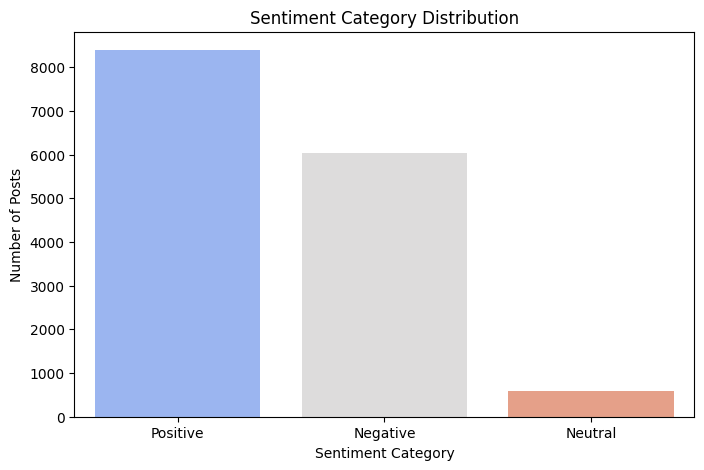

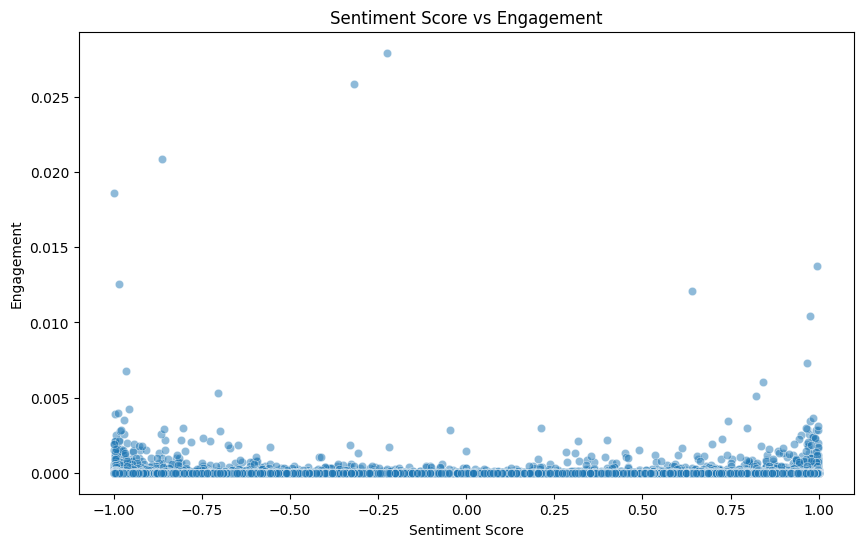

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize sentiment distribution
def visualize_sentiment(df):
    # Categorize sentiment scores into Negative, Neutral, Positive
    df['sentiment_category'] = df['sentiment_score'].apply(
        lambda x: 'Negative' if x < -0.05 else 'Neutral' if -0.05 <= x <= 0.05 else 'Positive'
    )
    
    # Visualize sentiment distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment_category', data=df, palette='coolwarm')
    plt.title('Sentiment Category Distribution')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Number of Posts')
    plt.show()

    # Scatter plot: Sentiment Score vs Engagement
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='sentiment_score', y='engagement', data=df, alpha=0.5)
    plt.title('Sentiment Score vs Engagement')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Engagement')
    plt.show()

# Visualize sentiment analysis results
visualize_sentiment(df)


Baseline Model (Logistic Regression) Validation Accuracy: 0.9111505997334518
              precision    recall  f1-score   support

           0       0.54      0.13      0.21        54
           1       0.92      1.00      0.95      2046
           2       0.44      0.03      0.05       151

    accuracy                           0.91      2251
   macro avg       0.63      0.38      0.40      2251
weighted avg       0.87      0.91      0.88      2251

Random Forest Validation Accuracy: 0.9431363838294091
              precision    recall  f1-score   support

           0       0.86      0.35      0.50        54
           1       0.95      1.00      0.97      2046
           2       0.89      0.45      0.60       151

    accuracy                           0.94      2251
   macro avg       0.90      0.60      0.69      2251
weighted avg       0.94      0.94      0.93      2251

Random Forest Testing Accuracy: 0.9431363838294091
              precision    recall  f1-score   support

 

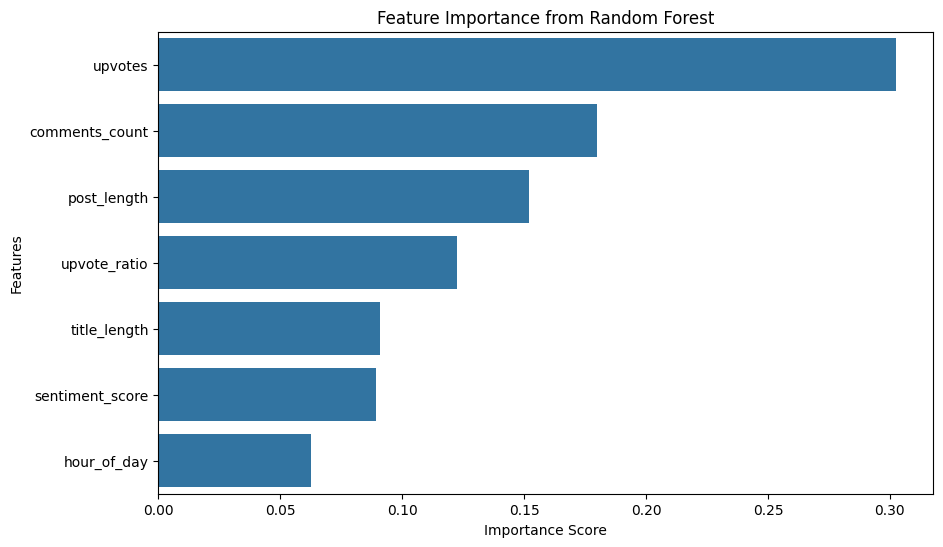

Cross-Validation Scores: [0.94240838 0.93907663 0.94431223 0.94669205 0.94857143]
Average Cross-Validation Score: 0.9442121438770654


In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Function to train and evaluate models
def train_and_evaluate(df, features, target):
    # Drop missing values
    df = df.dropna(subset=features + [target])

    # Encode the target variable
    label_encoder = LabelEncoder()
    df[target] = label_encoder.fit_transform(df[target])

    # Split data into training, validation, and testing sets
    X = df[features]
    y = df[target]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Scale numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Logistic Regression as baseline model
    baseline_model = LogisticRegression()
    baseline_model.fit(X_train, y_train)
    val_baseline_preds = baseline_model.predict(X_val)
    print("Baseline Model (Logistic Regression) Validation Accuracy:", accuracy_score(y_val, val_baseline_preds))
    print(classification_report(y_val, val_baseline_preds))

    # Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    val_preds = rf_model.predict(X_val)
    print("Random Forest Validation Accuracy:", accuracy_score(y_val, val_preds))
    print(classification_report(y_val, val_preds))

    # Test on the testing set
    test_preds = rf_model.predict(X_test)
    print("Random Forest Testing Accuracy:", accuracy_score(y_test, test_preds))
    print(classification_report(y_test, test_preds))

    # Feature importance
    feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importance from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

    # --- Cross-Validation (Optional) ---
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Average Cross-Validation Score:", np.mean(cv_scores))

# Define features and target for modeling
features = [
    'upvotes', 'comments_count', 'upvote_ratio', 'post_length', 'title_length',
    'sentiment_score', 'hour_of_day'
]
target = 'engagement_level'

# Train and evaluate models
train_and_evaluate(df, features, target)
